# Seasonal and Temporal Analysis

This notebook provides detailed analysis of seasonal patterns, daily cycles, and temporal trends in solar energy production.

**Key Analysis:**
- Monthly and seasonal production patterns
- Daily production curves and peak hours
- Year-over-year trends
- System performance over time

In [9]:
# Import libraries
import sys
sys.path.append('../src')

# Use standardized notebook utilities
from core.notebook_utils import load_with_analysis
from visualization.plot_config import setup_notebook_plots, SolarPlotConfig
from visualization.solar_charts import SolarVisualizationSuite
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime as dt, timedelta

# Set up plotting with solar-specific styling
plot_config = setup_notebook_plots(figsize=(12, 8))
SOLAR_COLORS = plot_config.SOLAR_COLORS

print("📈 Solar Energy Data Analysis - Seasonal & Temporal Patterns")
print("=" * 65)

📈 Solar Energy Data Analysis - Seasonal & Temporal Patterns


## 1. Load Data

In [10]:
# Load all data using standardized notebook utilities
notebook_data = load_with_analysis()

# Extract key components
data_manager = notebook_data['data_manager']
detector = notebook_data['detector'] 
location = notebook_data['location']
daily_data = notebook_data['daily_data']
csv_data = notebook_data['csv_data']

print(f"✅ Loaded {len(daily_data)} days of daily data")
print(f"✅ Loaded {len(csv_data):,} 15-minute intervals")
print(f"📅 Date range: {daily_data.index.min().date()} to {daily_data.index.max().date()}")

# Add location-specific context
print(f"\n🌍 Location-Specific Analysis:")
print(f"  System location: {location.location_name}")
print(f"  Climate type: {location.get_location_summary()['climate_type']}")

# Calculate expected vs actual patterns based on location
today = dt.now().date()
expected_sunrise, expected_sunset = location.get_sunrise_sunset(today)
expected_daylight = expected_sunset - expected_sunrise

print(f"  Expected daylight hours (today): {expected_daylight:.1f} hours")
print(f"  Summer daylight range: {location.get_location_summary()['summer_daylight_hours']:.1f} hours")
print(f"  Winter daylight range: {location.get_location_summary()['winter_daylight_hours']:.1f} hours")

INFO:core.location_manager:LocationManager initialized for Holly Springs, NC
INFO:core.data_manager:Loading CSV data from ../data/raw/4136754_custom_report.csv
INFO:core.data_manager:Loaded 70272 CSV records from 2023-09-16 00:00:00 to 2025-09-16 23:45:00
INFO:core.data_manager:Loading API data for last 30 days


📊 Determining Best Data Source...
✅ Using REAL Enphase API credentials!
   📈 Will attempt to fetch live data from your solar system
   🎯 PRIORITY: Real Enphase API data from your solar system
   📡 Will attempt live API data first
   📁 CSV fallback: ../data/raw/4136754_custom_report.csv

📋 Available Data Sources (in priority order):
   🎯 SELECTED: 📈 REAL CSV DATA - Real solar panel CSV data through 2025
      Available: 🎭 SYNTHETIC/MOCK DATA - Synthetic data for Holly Springs, NC (ends June 2024)
      Available: 🎭 GENERIC MOCK DATA - Generic synthetic data (ends March 2024)
✅ Notebook environment initialized for Holly Springs, NC


Error getting lifetime energy: 401

📈 Solar Data Loaded Successfully:
   🎯 DATA TYPE: 📈 REAL API DATA (with CSV fallback)
   📡 Source: 📁 CSV DATA
   📁 Source: CSV file (API failed, using fallback)
   📊 CSV Records: 70,272
   📅 CSV Date range: 2023-09-16 to 2025-09-16
   📅 Data recency: ✅ RECENT (8 days old)
   🕐 Latest data point: 2025-09-16

✅ SUCCESS: Using REAL solar production data!
   📈 Authentic solar panel data (not synthetic)
   📊 Contains data through 2025
   ℹ️ Note: API returned 401 (expired token), but CSV data is recent

🌍 Location Context:
  System location: Holly Springs, NC
  Coordinates: 35.663°N, -78.844°W
  Climate type: Temperate
  Timezone: America/Raleigh
✅ Loaded 732 days of daily data
✅ Loaded 70,272 15-minute intervals
📅 Date range: 2023-09-16 to 2025-09-16

🌍 Location-Specific Analysis:
  System location: Holly Springs, NC
  Climate type: Temperate
  Expected daylight hours (today): 11.8 hours
  Summer daylight range: 14.4 hours
  Winter daylight range: 9.6 ho

In [11]:
# Monthly analysis
monthly_stats = daily_data.groupby(daily_data.index.month).agg({
    'Production (kWh)': ['mean', 'sum', 'std', 'max', 'min']
}).round(2)

monthly_stats.columns = ['Avg Daily', 'Total', 'Std Dev', 'Peak Day', 'Min Day']

print("=== MONTHLY PRODUCTION STATISTICS ===")
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
monthly_stats.index = [month_names[i-1] for i in monthly_stats.index]
print(monthly_stats)

# Find best and worst months
best_month = monthly_stats['Avg Daily'].idxmax()
worst_month = monthly_stats['Avg Daily'].idxmin()
print(f"\n🌞 Best production month: {best_month} ({monthly_stats.loc[best_month, 'Avg Daily']:.1f} kWh/day avg)")
print(f"☁️ Lowest production month: {worst_month} ({monthly_stats.loc[worst_month, 'Avg Daily']:.1f} kWh/day avg)")
print(f"📊 Seasonal variation: {monthly_stats['Avg Daily'].max() / monthly_stats['Avg Daily'].min():.1f}x difference")

=== MONTHLY PRODUCTION STATISTICS ===
     Avg Daily    Total  Std Dev  Peak Day  Min Day
Jan      30.43  1886.59    14.02     45.00     2.35
Feb      32.78  1868.40    17.65     50.94     3.23
Mar      38.75  2402.71    16.78     58.33     4.20
Apr      43.41  2604.60    14.99     59.91     6.47
May      40.72  2524.87    15.08     61.33     6.09
Jun      46.64  2798.43     9.41     59.21    10.78
Jul      41.62  2580.21    12.39     58.25     7.14
Aug      39.44  2445.02    14.02     57.45     8.12
Sep      35.14  2143.52    16.05     56.50     2.16
Oct      40.82  2530.87    11.27     53.38     2.68
Nov      31.70  1901.76    13.41     48.88     3.03
Dec      27.60  1711.36    13.32     41.19     0.63

🌞 Best production month: Jun (46.6 kWh/day avg)
☁️ Lowest production month: Dec (27.6 kWh/day avg)
📊 Seasonal variation: 1.7x difference


## 2. Monthly Production Analysis

🎨 Creating comprehensive seasonal analysis dashboard...


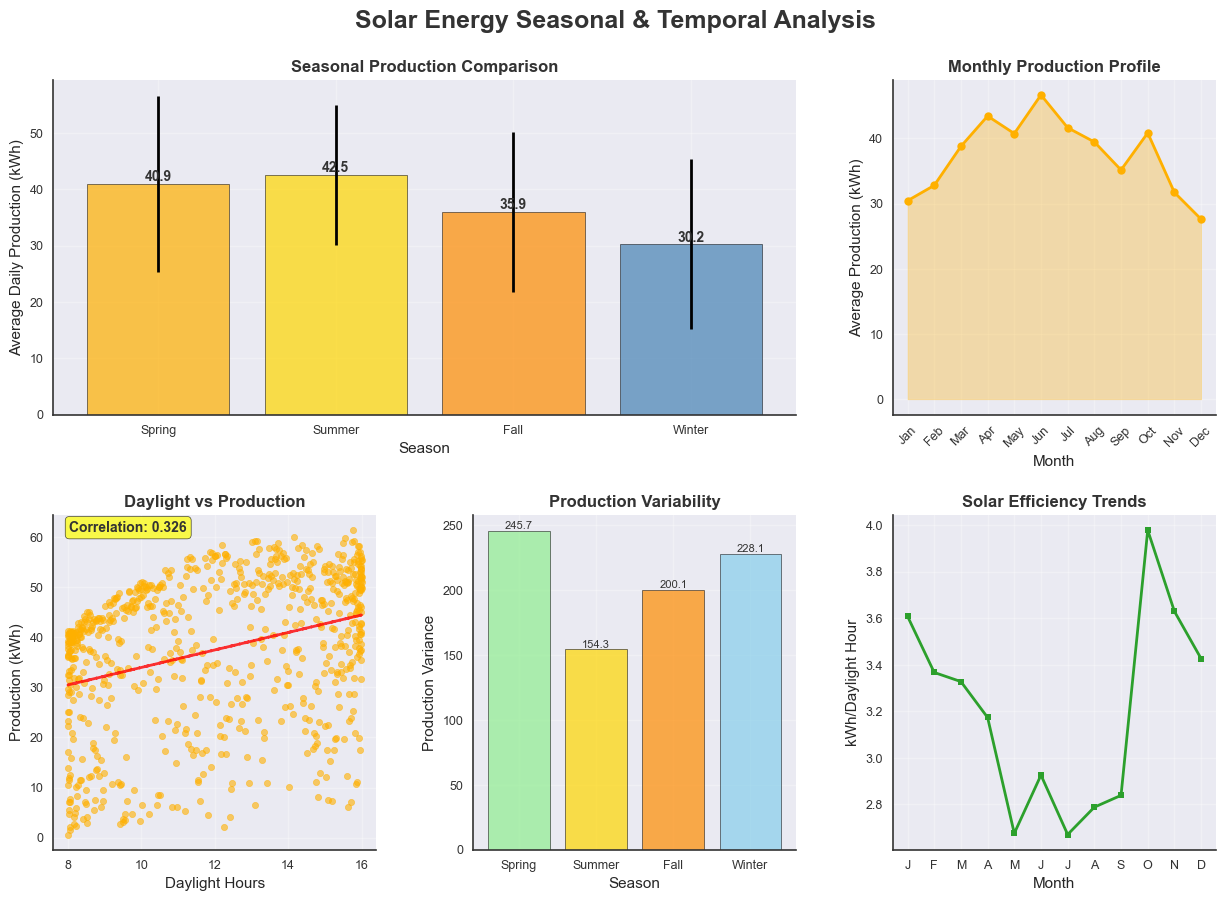

✨ Seasonal dashboard created successfully!
📄 Saved to: ../plots/seasonal_analysis_dashboard.png


In [12]:
# Initialize SolarVisualizationSuite for professional seasonal analysis
viz_suite = SolarVisualizationSuite(style='default')

# Prepare data for visualization
viz_data = daily_data.reset_index().rename(columns={
    'Date/Time': 'date',
    'Production (kWh)': 'production'
})

# Ensure plots directory exists
from pathlib import Path
Path("../plots").mkdir(exist_ok=True)

# Create comprehensive seasonal analysis dashboard
print("🎨 Creating comprehensive seasonal analysis dashboard...")
seasonal_dashboard = viz_suite.create_seasonal_analysis_dashboard(
    daily_data=viz_data,
    title="Solar Energy Seasonal & Temporal Analysis",
    save_path="../plots/seasonal_analysis_dashboard.png"
)

plt.show()

print("✨ Seasonal dashboard created successfully!")
print("📄 Saved to: ../plots/seasonal_analysis_dashboard.png")

## 3. Daily Production Patterns

In [13]:
# Hourly patterns analysis
if len(csv_data) > 0:
    csv_data['Hour'] = csv_data.index.hour
    csv_data['Month'] = csv_data.index.month
    
    # Average hourly production
    hourly_avg = csv_data.groupby('Hour')['Production (kWh)'].mean()
    
    print("=== DAILY PRODUCTION PATTERNS ===")
    print(f"Peak production hour: {hourly_avg.idxmax()}:00 ({hourly_avg.max():.3f} kWh avg)")
    print(f"First significant production: {hourly_avg[hourly_avg > 0.01].index.min()}:00")
    print(f"Last significant production: {hourly_avg[hourly_avg > 0.01].index.max()}:00")
    
    # Daylight hours analysis
    daylight_hours = hourly_avg[hourly_avg > 0.01]
    print(f"Productive daylight hours: {len(daylight_hours)} hours")
    print(f"Peak period (>50% of max): {len(hourly_avg[hourly_avg > hourly_avg.max()*0.5])} hours")

=== DAILY PRODUCTION PATTERNS ===
Peak production hour: 11:00 (1.386 kWh avg)
First significant production: 6:00
Last significant production: 19:00
Productive daylight hours: 14 hours
Peak period (>50% of max): 7 hours


📈 Creating standardized daily pattern visualizations...


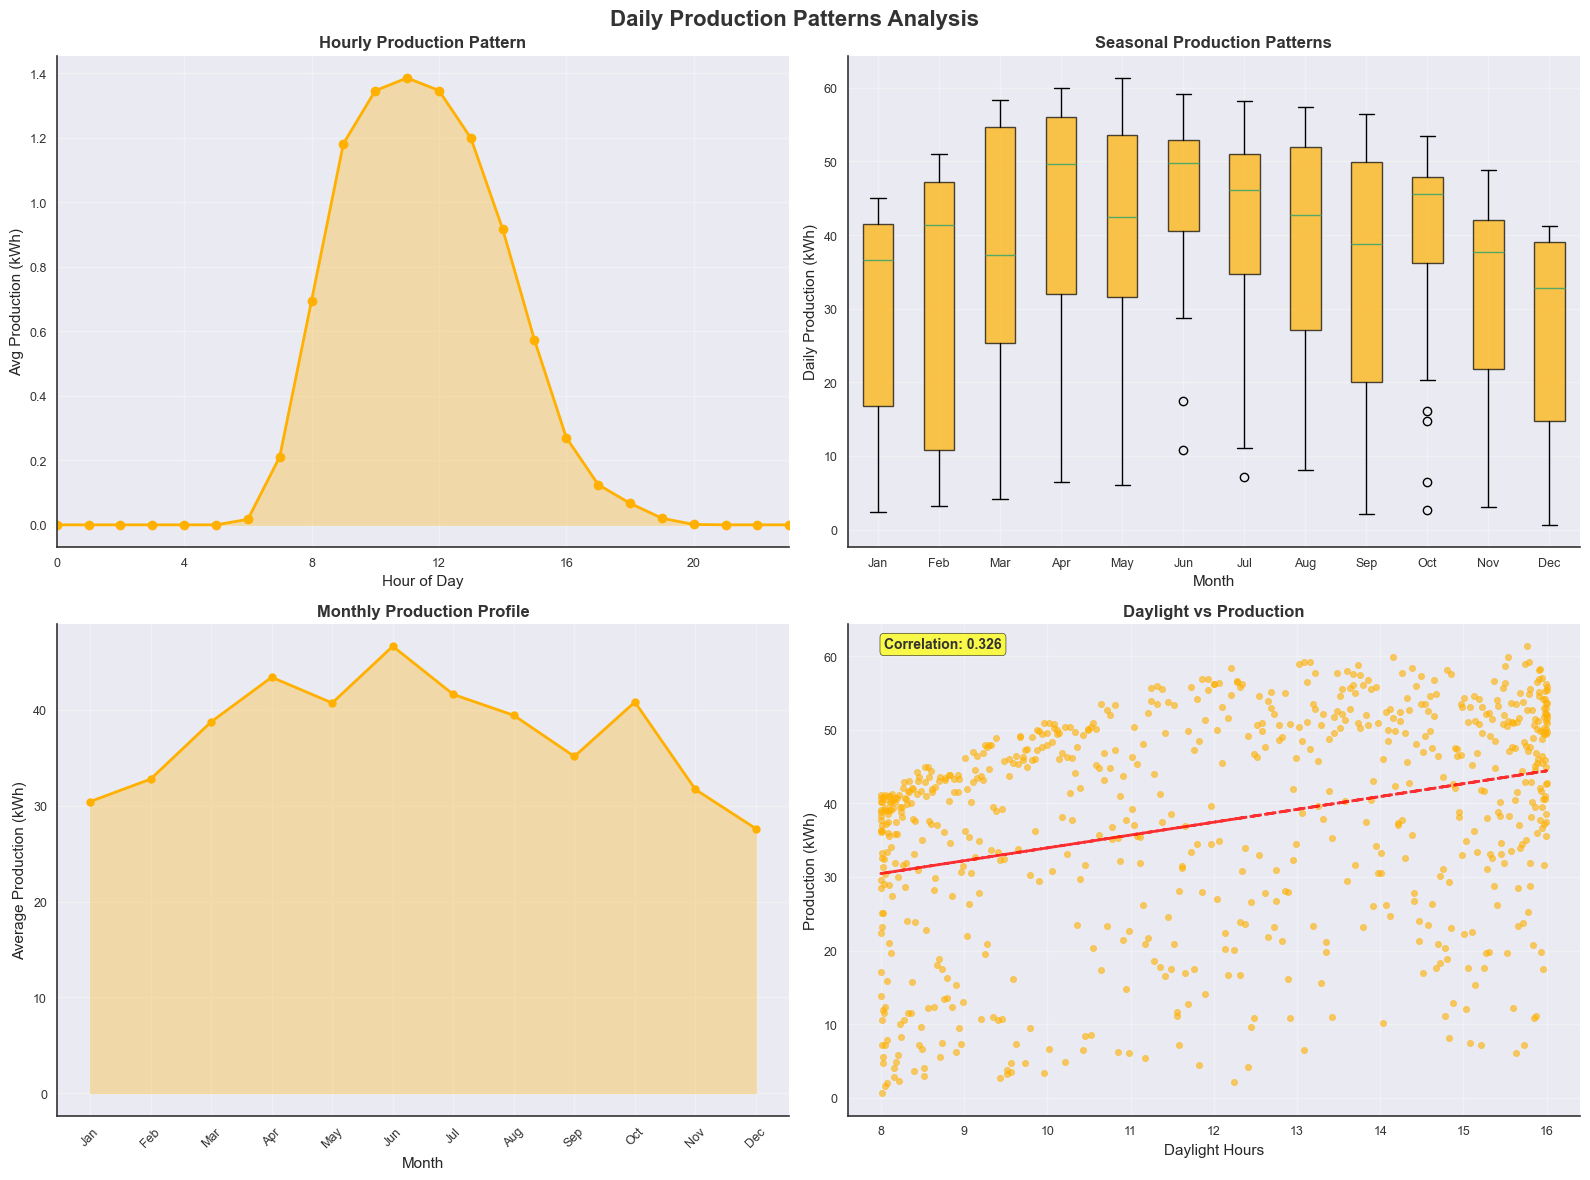

✨ Daily pattern analysis complete with professional styling!


In [14]:
# Daily pattern visualization using SolarVisualizationSuite
if len(csv_data) > 0:
    print("📈 Creating standardized daily pattern visualizations...")
    
    # Prepare hourly data for visualization
    csv_data['Hour'] = csv_data.index.hour
    hourly_data = csv_data.reset_index().rename(columns={
        'Date/Time': 'date',
        'Production (kWh)': 'production'
    })
    hourly_data['hour'] = hourly_data['date'].dt.hour
    
    # Create individual professional charts using the suite
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Use individual plotting methods from the suite for consistent styling
    viz_suite._plot_hourly_patterns(axes[0,0], hourly_data)
    viz_suite._plot_seasonal_patterns(axes[0,1], viz_data) 
    
    # Monthly production distribution using suite styling
    seasonal_data = viz_suite._prepare_seasonal_data(viz_data)
    viz_suite._plot_monthly_averages(axes[1,0], seasonal_data)
    viz_suite._plot_daylight_correlation(axes[1,1], seasonal_data)
    
    plt.suptitle('Daily Production Patterns Analysis', fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()
    
    print("✨ Daily pattern analysis complete with professional styling!")

## 4. System Performance Trends

📊 Creating professional performance trend visualizations...


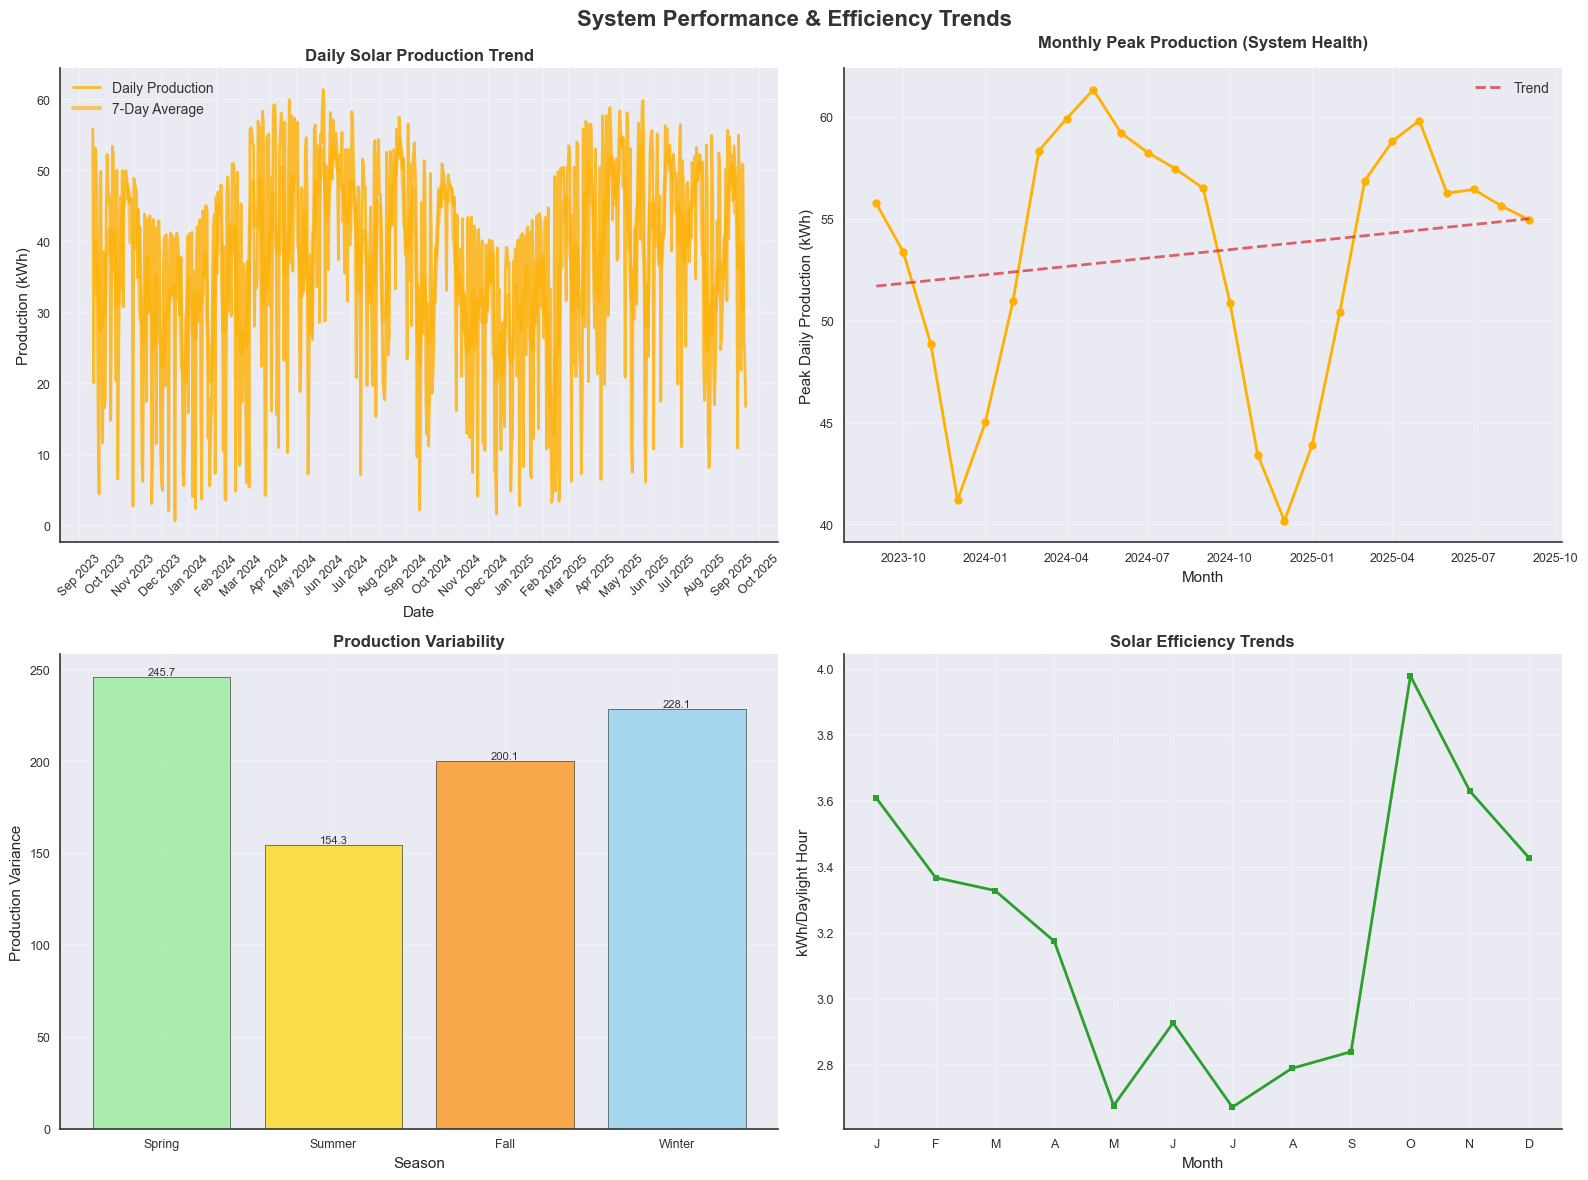

✨ Performance trend analysis complete with professional styling!


In [15]:
# Performance trends visualization using SolarVisualizationSuite
print("📊 Creating professional performance trend visualizations...")

# Rolling averages
daily_data['7day_avg'] = daily_data['Production (kWh)'].rolling(7, center=True).mean()
daily_data['30day_avg'] = daily_data['Production (kWh)'].rolling(30, center=True).mean()

# Create enhanced performance trend analysis using the suite
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Use the suite's production trend method
viz_suite._plot_production_trend(axes[0,0], viz_data)

# Monthly peak production using suite styling  
monthly_peaks = daily_data.groupby([daily_data.index.year, daily_data.index.month])['Production (kWh)'].max()
peak_dates = [pd.Timestamp(year=year, month=month, day=1) for (year, month) in monthly_peaks.index]

from visualization.plot_config import format_solar_axes, SOLAR_COLORS
axes[0,1].plot(peak_dates, monthly_peaks.values, marker='o', linewidth=2, markersize=6,
               color=SOLAR_COLORS['production'])
format_solar_axes(axes[0,1], 'Month', 'Peak Daily Production (kWh)', 
                  'Monthly Peak Production (System Health)')

# Add trend line
if len(monthly_peaks) > 3:
    from numpy.polynomial import Polynomial
    x_numeric = [(d - peak_dates[0]).days for d in peak_dates]
    p = Polynomial.fit(x_numeric, monthly_peaks.values, 1)
    trend_line = p(x_numeric)
    axes[0,1].plot(peak_dates, trend_line, '--', color=SOLAR_COLORS['import'], alpha=0.7, label='Trend')
    axes[0,1].legend()

# Production variance using suite styling
seasonal_data = viz_suite._prepare_seasonal_data(viz_data)
viz_suite._plot_production_variance(axes[1,0], seasonal_data)

# Efficiency trends using suite method
viz_suite._plot_efficiency_trends(axes[1,1], seasonal_data)

plt.suptitle('System Performance & Efficiency Trends', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

print("✨ Performance trend analysis complete with professional styling!")

## 5. Key Insights Summary

In [16]:
print("=== KEY SEASONAL & TEMPORAL INSIGHTS ===")

# Seasonal insights
seasonal_avg = daily_data.groupby(daily_data.index.quarter)['Production (kWh)'].mean()
best_season = seasonal_avg.idxmax()
worst_season = seasonal_avg.idxmin()
season_names_full = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}

print(f"\n🌍 SEASONAL PATTERNS:")
print(f"  Best season: {season_names_full[best_season]} (Q{best_season}) - {seasonal_avg[best_season]:.1f} kWh/day")
print(f"  Worst season: {season_names_full[worst_season]} (Q{worst_season}) - {seasonal_avg[worst_season]:.1f} kWh/day")
print(f"  Seasonal variation: {seasonal_avg.max()/seasonal_avg.min():.1f}x difference")

# Compare with location expectations
location_summary = location.get_location_summary()
expected_variation = location_summary['seasonal_variation']
actual_variation = seasonal_avg.max()/seasonal_avg.min() - 1

print(f"\n📍 LOCATION-SPECIFIC INSIGHTS:")
print(f"  Location: {location.location_name}")
print(f"  Climate type: {location_summary['climate_type']}")
print(f"  Expected seasonal variation: {expected_variation:.1f}")
print(f"  Actual seasonal variation: {actual_variation:.1f}")
print(f"  Performance vs climate expectation: {'Higher' if actual_variation > expected_variation else 'Lower'} than typical for {location_summary['climate_type'].lower()} climates")

# Daily patterns
if len(csv_data) > 0:
    print(f"\n☀️ DAILY PATTERNS:")
    print(f"  Peak hour: {hourly_avg.idxmax()}:00 ({hourly_avg.max():.3f} kWh average)")
    productive_hours = hourly_avg[hourly_avg > 0.01]
    print(f"  Productive hours: {productive_hours.index.min()}:00 to {productive_hours.index.max()}:00")
    print(f"  Total productive hours: {len(productive_hours)} hours/day")
    
    # Compare with theoretical daylight
    avg_daylight = (location_summary['summer_daylight_hours'] + location_summary['winter_daylight_hours']) / 2
    print(f"  Theoretical avg daylight: {avg_daylight:.1f} hours")
    print(f"  Solar utilization efficiency: {len(productive_hours)/avg_daylight*100:.0f}%")

# Performance trends
if len(monthly_peaks) > 6:
    recent_peaks = monthly_peaks.tail(6).mean()
    early_peaks = monthly_peaks.head(6).mean()
    trend_direction = "improving" if recent_peaks > early_peaks else "declining"
    print(f"\n📈 PERFORMANCE TRENDS:")
    print(f"  System performance: {trend_direction}")
    print(f"  Recent peak average: {recent_peaks:.1f} kWh")
    print(f"  Early peak average: {early_peaks:.1f} kWh")

# Production statistics
total_production = daily_data['Production (kWh)'].sum()
days_analyzed = len(daily_data)
print(f"\n📊 OVERALL STATISTICS:")
print(f"  Total production analyzed: {total_production:,.0f} kWh")
print(f"  Days analyzed: {days_analyzed:,} days")
print(f"  Average daily production: {total_production/days_analyzed:.1f} kWh/day")
print(f"  Estimated annual production: {(total_production/days_analyzed)*365:.0f} kWh/year")

print("\n✅ Seasonal and temporal analysis complete!")
print("\nNext steps:")
print("- Run 01c_baseline_ml_models.ipynb for machine learning forecasting")
print("- Run 02_weather_integration.ipynb for weather-enhanced analysis")

=== KEY SEASONAL & TEMPORAL INSIGHTS ===

🌍 SEASONAL PATTERNS:
  Best season: Spring (Q2) - 43.6 kWh/day
  Worst season: Fall (Q4) - 33.4 kWh/day
  Seasonal variation: 1.3x difference

📍 LOCATION-SPECIFIC INSIGHTS:
  Location: Holly Springs, NC
  Climate type: Temperate
  Expected seasonal variation: 0.5
  Actual seasonal variation: 0.3
  Performance vs climate expectation: Lower than typical for temperate climates

☀️ DAILY PATTERNS:
  Peak hour: 11:00 (1.386 kWh average)
  Productive hours: 6:00 to 19:00
  Total productive hours: 14 hours/day
  Theoretical avg daylight: 12.0 hours
  Solar utilization efficiency: 117%

📈 PERFORMANCE TRENDS:
  System performance: improving
  Recent peak average: 57.0 kWh
  Early peak average: 49.2 kWh

📊 OVERALL STATISTICS:
  Total production analyzed: 27,398 kWh
  Days analyzed: 732 days
  Average daily production: 37.4 kWh/day
  Estimated annual production: 13662 kWh/year

✅ Seasonal and temporal analysis complete!

Next steps:
- Run 01c_baseline_ml_